# Exploring the TensorFlow models

In this notebook we will utilise some simple dense neural networks in finding Ricci-flat Calabi-Yau metrics. 
In particular we will make use of the following three tensorflow models.

1. *MultFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} ( 1 + g_{NN})$.
2. *PhiFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} + \partial \bar{\partial} g_{NN}$.
2. *ToricPhiFSModel*: is the same as *PhiFSModel*, but for toric CYs.

This notebook assumes that [1.PointGenerator](1.PointGenerator.ipynb) has generated datasets for the Fermat quintic.

In [1]:
import numpy as np
import os as os
import tensorflow as tf
tfk = tf.keras

## MultFSModel 

The *MultFSModel* works for any CICY.

### Data preprocessing

We load the dataset and also the generated basis from *PointGenerator*

In [2]:
dirname = 'fermat_pg'

In [3]:
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)

tensorflow can only compute derivatives w.r.t. tensor objects. Thus we transform the *BASIS* using

In [4]:
from cymetric.models.tfhelper import prepare_tf_basis

In [5]:
BASIS = prepare_tf_basis(BASIS)

2021-09-14 16:09:35.746971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 16:09:35.752207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 16:09:35.752560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 16:09:35.753612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Our integration weights set the overall volume of the CY. This parameter is usually denoted with $\kappa$ and contributes directly in the MA equation. We compute the kappa value for the training data.

In [6]:
kappa = 1/np.mean(data['y_train'][:,-2])
kappa

0.10561818772788945

which corresponds to a volume of

In [7]:
1/kappa

9.46806626313605

### NN set up

The *cymetric*-TensorFlow models are custom models and come with custom needs. We have written several callbacks and metrics to track the training progress.

In [8]:
from cymetric.models.callbacks import RicciCallback, SigmaCallback, VolkCallback
from cymetric.models.tfmodels import MultFSModel
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, VolkLoss, RicciLoss, TotalLoss

We define some callbacks to evaluate the performance of our models on the

1. Ricci-measure
2. Sigma-measure
3. Volume

In [9]:
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
scb = SigmaCallback((data['X_val'], data['y_val']))
volkcb = VolkCallback((data['X_val'], data['y_val']))
cb_list = [rcb, scb, volkcb]

set some hyperparameters for the NN

In [10]:
nlayer = 3
nHidden = 64
act = 'gelu'
nEpochs = 30
bSize = 64
alpha = [1., 1., 1., 1., 1.]
nfold = 3
n_in = 2*5
n_out = nfold**2

and finally set up the neural net

In [11]:
nn = tf.keras.Sequential()
nn.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn.add(tfk.layers.Dense(nHidden, activation=act))
nn.add(tfk.layers.Dense(n_out))

In [12]:
help(MultFSModel)

Help on class MultFSModel in module cymetric.models.tfmodels:

class MultFSModel(FreeModel)
 |  MultFSModel(*args, **kwargs)
 |  
 |  MultFSModel inherits from :py:class:`FreeModel`.
 |  
 |  Example:
 |      Is identical to :py:class:`FreeModel`. Replace the model accordingly.
 |  
 |  Method resolution order:
 |      MultFSModel
 |      FreeModel
 |      cymetric.models.fubinistudy.FSModel
 |      keras.engine.training.Model
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.tracking.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      keras.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      MultFSModel is a tensorflow model predicting CY metrics.
 |      
 |      The output of this model has the following Ansatz
 |      
 |      .. 

the *MultFSModel* requires as arguments 

1. the nn, which we have defined above, 
2. the *PointGenerator*-*BASIS* which contains all relevant information of the underlying Calabi-Yau.

It has optional arguments for

1. The overall volume of the CY. We give kappa to stay at the same volume as the integration weights.
2. alpha, which weights the different loss contributions (1-MA loss, 2-Kähler loss, 3-transition loss, 4-Ricci loss (by default disabled), 5-volk loss).

In [13]:
fmodel = MultFSModel(nn, BASIS, kappa=kappa, alpha=alpha)

we define some custom metrics to track our training progress and the optimizer

In [14]:
cmetrics = [TotalLoss(), SigmaLoss(), KaehlerLoss(), TransitionLoss(), VolkLoss(), RicciLoss()]
opt = tfk.optimizers.Adam()

compile the model

In [15]:
fmodel.compile(custom_metrics = cmetrics, optimizer=opt)

Next, we start the training process. It is recommended to use the integration weights as *sample_weights*. Furthermore, one can also add a separate valitadion_split.

In [16]:
sw = data['y_train'][:,0]

In [17]:
history = fmodel.fit(data['X_train'], data['y_train'],
                     epochs=nEpochs, batch_size=bSize,
                     validation_split=0.1, verbose=1,
                     callbacks=cb_list, sample_weight=sw)

2021-09-14 16:09:49.362339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-14 16:09:50.733763: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x55f37e258180


 - Ricci measure val:      0.2391
 - Sigma measure val:      0.3764
 - Volk val:               0.1690
Epoch 1/30


/home/robin/miniconda3/envs/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_5_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_5_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_5_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/robin/miniconda3/envs/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_4_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_4_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_4_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may con

1266/1266 [==============================] - 47s 27ms/step - loss: 1.9320 - sigma_loss: 1.6648 - kaehler_loss: 0.1165 - transition_loss: 0.1469 - volk_loss: 0.0038 - ricci_loss: 0.0000e+00 - val_loss: 1.6164 - val_sigma_loss: 0.9899 - val_kaehler_loss: 0.1469 - val_transition_loss: 0.1011 - val_volk_loss: 0.3785 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      2.2460
 - Sigma measure val:      0.1047
 - Volk val:               1.0004
Epoch 2/30
1266/1266 [==============================] - 31s 25ms/step - loss: 1.1254 - sigma_loss: 0.9196 - kaehler_loss: 0.1424 - transition_loss: 0.0597 - volk_loss: 0.0037 - ricci_loss: 0.0000e+00 - val_loss: 1.4407 - val_sigma_loss: 0.8672 - val_kaehler_loss: 0.1426 - val_transition_loss: 0.0491 - val_volk_loss: 0.3818 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      1.9664
 - Sigma measure val:      0.0920
 - Volk val:               0.9883
Epoch 3/30
1266/1266 [==============================] - 32s 25ms/step - loss: 1.0816 - sigma_loss: 

1266/1266 [==============================] - 31s 25ms/step - loss: 0.9215 - sigma_loss: 0.7651 - kaehler_loss: 0.1136 - transition_loss: 0.0390 - volk_loss: 0.0038 - ricci_loss: 0.0000e+00 - val_loss: 1.3142 - val_sigma_loss: 0.7937 - val_kaehler_loss: 0.1161 - val_transition_loss: 0.0399 - val_volk_loss: 0.3645 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      1.6953
 - Sigma measure val:      0.0839
 - Volk val:               1.0156
Epoch 20/30
1266/1266 [==============================] - 31s 25ms/step - loss: 0.9123 - sigma_loss: 0.7572 - kaehler_loss: 0.1130 - transition_loss: 0.0383 - volk_loss: 0.0038 - ricci_loss: 0.0000e+00 - val_loss: 1.3082 - val_sigma_loss: 0.7720 - val_kaehler_loss: 0.1174 - val_transition_loss: 0.0402 - val_volk_loss: 0.3786 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      1.6423
 - Sigma measure val:      0.0802
 - Volk val:               0.9932
Epoch 21/30
1266/1266 [==============================] - 31s 25ms/step - loss: 0.9037 - sigma_loss

In the training process the ricci_loss is zero, because it has been disabled so we don't have to compute two additional derivatives during training. We keep track of the Ricci measure with the callbacks. The vol k callback shoudl be == 1 for the CY to have the same overall volume.

All metrics and callbacks are written to *history.history*.

In [18]:
for key in history.history:
    print(key)

loss
sigma_loss
kaehler_loss
transition_loss
volk_loss
ricci_loss
val_loss
val_sigma_loss
val_kaehler_loss
val_transition_loss
val_volk_loss
val_ricci_loss
ricci_val
sigma_val
volk_val


### Fancy plots

and make some fancy plots. The packages below are not required for *cymetric*, so you might have to install them by hand.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

<AxesSubplot:title={'center':'Ricci measure'}, xlabel='sigma_val', ylabel='ricci_val'>

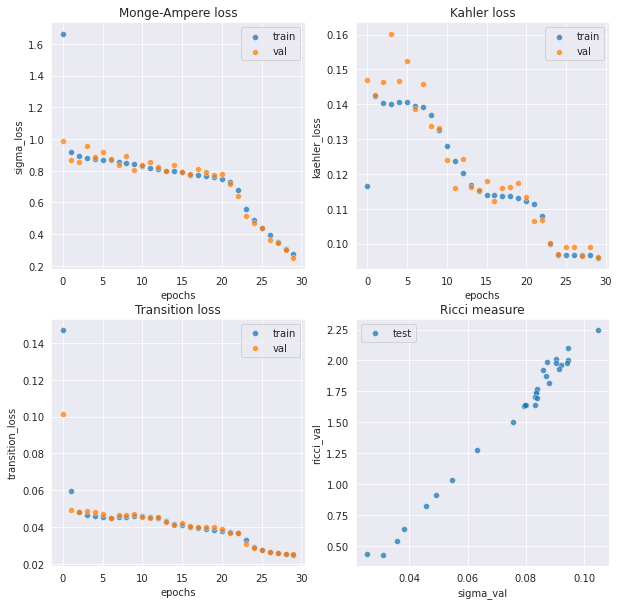

In [20]:
hist = history.history
hist['epochs'] = list(range(nEpochs))
hist_data = pd.DataFrame(hist)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='val_sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Kahler loss")
sns.scatterplot(x='epochs', y='kaehler_loss', data=hist_data, alpha=0.75, ax=ax2, label="train")
sns.scatterplot(x='epochs', y='val_kaehler_loss', data=hist_data, alpha=0.75, ax=ax2, label="val")

ax3.set_title("Transition loss")
sns.scatterplot(x='epochs', y='transition_loss', data=hist_data, alpha=0.75, ax=ax3, label="train")
sns.scatterplot(x='epochs', y='val_transition_loss', data=hist_data, alpha=0.75, ax=ax3, label="val")

ax4.set_title("Ricci measure")
sns.scatterplot(x='sigma_val', y='ricci_val', data=hist_data, alpha=0.75, ax=ax4, label="test")

and we find a nice slope going towards the origin for optimization of the MA equation.

## The PhiFSModel

is set up similar to the *MultFSModel*.

### The NN

now has a single output. We disable the bias in the last layer, because it's contribution will also be zero after taking the two derivatives w.r.t to the input coordinates.

In [21]:
n_out = 1
nn_phi = tf.keras.Sequential()
nn_phi.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn_phi.add(tfk.layers.Dense(nHidden, activation=act))
nn_phi.add(tfk.layers.Dense(n_out, use_bias = False))

In [22]:
from cymetric.models.tfmodels import PhiFSModel

In [23]:
phimodel = PhiFSModel(nn_phi, BASIS, kappa=kappa, alpha=alpha)
opt_phi = tfk.optimizers.Adam()
phimodel.compile(custom_metrics = cmetrics, optimizer=opt_phi)

and fit

In [24]:
history = phimodel.fit(data['X_train'], data['y_train'],
                     epochs=1, batch_size=bSize,
                     validation_split=0.1, verbose=1,
                     callbacks=cb_list, sample_weight=sw)

 - Ricci measure val:      0.2518
 - Sigma measure val:      0.3650
 - Volk val:               0.1783


/home/robin/miniconda3/envs/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_5_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_5_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_5_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/robin/miniconda3/envs/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_4_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_4_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_4_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may con

1266/1266 [==============================] - 48s 29ms/step - loss: 1.9912 - sigma_loss: 1.7870 - kaehler_loss: 0.0000e+00 - transition_loss: 0.2042 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - val_loss: 1.8329 - val_sigma_loss: 1.6872 - val_kaehler_loss: 0.0000e+00 - val_transition_loss: 0.1457 - val_volk_loss: 0.0000e+00 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      2.5585
 - Sigma measure val:      0.1745
 - Volk val:               0.9532


we find that in addition to the ricci-loss also the kaehler-loss and volk-loss are zero. Those two are by construction satisfied in the $\phi$-network and thus disabled.

## The ToricPhiFSModel

requires additional toric data.

### The NN

is the same as for the *PhiFSModel*.

In [25]:
n_out = 1
nn_phit = tf.keras.Sequential()
nn_phit.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn_phit.add(tfk.layers.Dense(nHidden, activation=act))
nn_phit.add(tfk.layers.Dense(n_out, use_bias = False))

In [26]:
from cymetric.models.tfmodels import PhiFSModelToric

load toric data

In [27]:
dirname = 'fermat_pgtoric'
toric_data = np.load(os.path.join(dirname, 'toric_data.pickle'), allow_pickle=True)

In [28]:
phimodel_toric = PhiFSModelToric(nn_phi, BASIS, kappa=kappa, alpha=alpha, toric_data=toric_data)
opt_phit = tfk.optimizers.Adam()
phimodel_toric.compile(custom_metrics = cmetrics, optimizer=opt_phit)

and fit

In [29]:
history = phimodel_toric.fit(data['X_train'], data['y_train'],
                             epochs=1, batch_size=bSize,
                             validation_split=0.1, verbose=1,
                             callbacks=cb_list, sample_weight=sw)

 - Ricci measure val:      2.5585
 - Sigma measure val:      0.1745
 - Volk val:               0.9532


/home/robin/miniconda3/envs/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:1", shape=(None,), dtype=int64), values=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:0", shape=(None, 5), dtype=complex64), dense_shape=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1266/1266 [==============================] - 49s 29ms/step - loss: 1.6610 - sigma_loss: 1.5448 - kaehler_loss: 0.0000e+00 - transition_loss: 0.1162 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - val_loss: 1.5889 - val_sigma_loss: 1.4976 - val_kaehler_loss: 0.0000e+00 - val_transition_loss: 0.0913 - val_volk_loss: 0.0000e+00 - val_ricci_loss: 0.0000e+00
 - Ricci measure val:      2.3100
 - Sigma measure val:      0.1564
 - Volk val:               1.0362
